<b>Breast Cancer Wisconsin (Diagnostic) Data Set</b> 
(reference to UCI Machine Learning Repository <a href="http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29">description</a>)

In [1]:
# References
# Compare results https://plot.ly/~s143717/87.embed
# https://github.com/kzky/python-online-machine-learning-library/tree/master/evaluation/uci_small_dataset
# https://github.com/tmadl/sklearn-random-rotation-ensembles
# https://books.google.com/books?id=dltICgAAQBAJ&pg=PA29&lpg=PA29&dq=ionosphere+sklearn&source=bl&ots=MqQk59GzAh&sig=77iP6Lo3YaGBqPO1pAdTiZH7cLY&hl=en&sa=X&ved=0ahUKEwjF7MymmpfXAhWBOCYKHak7DtoQ6AEIRDAE#v=onepage&q=ionosphere%20sklearn&f=false

In [2]:
# coding: utf-8
import multiprocessing 
multiprocessing.set_start_method('spawn')

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8

from IPython.display import display
import pickle

import numpy as np
np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

import pandas as pd
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 200)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision', 6)

from collections import Counter

import seaborn as sns
sns.set()

from tqdm import tqdm_notebook, tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from imblearn.pipeline import Pipeline

import torch
from torch import nn

from lib.utils import *

from lib.classifier import Classifier, torch_weight_init, Stopping, OutlierSampler, exp_decay, to_var, PytorchLogger

from lib.model import MLP, MLP_vanilla

%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-09-13 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 85%


In [4]:
# Hyperparameters
HP = HYPERPARAMETERS({
    "GPU"                 : True ,
    "SEED"                : 0
})

In [5]:
# if not HP.SEED:
#     torch.cuda.is_available = lambda : False

# Seed random generators for repro 
np.random.seed(HP.SEED)  
# torch.manual_seed(HP.SEED);
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(HP.SEED)

In [6]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
feature_names = dataset.feature_names
target_names = dataset.target_names
data = pd.DataFrame(np.c_[dataset['target'], dataset['data']], columns= np.append(['diagnosis'], feature_names ))

X = np.float32(data.drop('diagnosis', axis=1).values)
y = np.int64(data['diagnosis'].values)   # conversion to int64 for pytorch

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=HP.SEED)

dataset_statistics(X_train, y_train, X_test, y_test, target_names)


Dataset statistics:
number of features:       30
number of classes:        2
data type:                float32
number of train samples:  381 (pos=236, neg=145, size=0MB)
number of test samples:   188 (pos=121, neg=67, size=0MB)
labels                    ['malignant' 'benign']


In [7]:
params = {
    'module'                       : MLP,
    'module_H'                     : 12,
    'module_D_in'                  : X_train.shape[1] ,
    'module_D_out'                 : 2 ,

    'module_initialize'            : torch_weight_init ,

    'max_epochs'                   : 1000,
    'batch_size'                   : 100 ,
    'batch_shuffle'                : True,

    'optimizer'                    : torch.optim.SGD ,
    'optimizer_lr'                 : 0.5 ,
    'optimizer_momentum'           : 0.9 ,
    'optimizer_weight_decay'       : 5e-4 ,
    'optimizer_nesterov'           : True ,

    'criterion'                    : nn.CrossEntropyLoss ,
    'criterion_size_average'       : True ,

    'scheduler'                    : torch.optim.lr_scheduler.LambdaLR ,
    'scheduler_lr_lambda'          : exp_decay ,

    'stopping'                     : Stopping ,
    'stopping_patience'            : 120 ,

    'scoring'                      : metrics.f1_score ,

    'random_state'                 : 10
}

In [8]:
pipeline = Pipeline(steps=[
                ('scaler',     MinMaxScaler(copy=True)),
                ('outlier',    OutlierSampler(8.5)),
                ('sampler',    RandomOverSampler(random_state=HP.SEED)),
                ('classifier', Classifier(**params))
                ])

In [9]:
param_grid = {
    'classifier__module'                       : [MLP, MLP_vanilla],
    'classifier__module_H'                     : [ 15, 20, 25] , 
    'classifier__module_D_in'                  : [X_train.shape[1]] ,
    'classifier__module_D_out'                 : [2] ,

    'classifier__module_initialize'            : [torch_weight_init] ,

    'classifier__max_epochs'                   : [1000],
    'classifier__batch_size'                   : [80, 100, 120] ,
    'classifier__batch_shuffle'                : [True],

    'classifier__optimizer'                    : [torch.optim.SGD] ,
    'classifier__optimizer_lr'                 : [0.5, 0.1, 0.05] ,
    'classifier__optimizer_momentum'           : [0.9] ,
    'classifier__optimizer_weight_decay'       : [5e-4] ,
    'classifier__optimizer_nesterov'           : [True] ,

    'classifier__criterion'                    : [nn.CrossEntropyLoss] ,
    'classifier__criterion_size_average'       : [True] ,

    'classifier__scheduler'                    : [torch.optim.lr_scheduler.LambdaLR] ,
    'classifier__scheduler_lr_lambda'          : [exp_decay] ,

    'classifier__stopping'                     : [Stopping] ,
    'classifier__stopping_patience'            : [100, 120, 140] ,

    'classifier__scoring'                      : [metrics.f1_score] ,

    'classifier__random_state'                 : [10]
}

scoring = None

In [10]:
NUM_TRIALS = 3

trial_scores_columns = ['best_score', 'best_parameters', 'estimator',
                        'trial', 'score_mean', 'score_std', 'score_min', 'score_max']
trial_scores = pd.DataFrame(columns=trial_scores_columns)
for trial in tqdm(range(NUM_TRIALS)):
    
    cv = KFold(n_splits=4, shuffle=True, random_state=trial)
    gscv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring=scoring, 
                        verbose=0, n_jobs=4)
    gscv.fit(X_train, y_train)

    best_estimator = pickle.dumps(gscv.best_estimator_)
    best_score = gscv.best_score_
    best_parameters = gscv.best_params_

    cv = KFold(n_splits=10, shuffle=True, random_state=trial).split(X_train)
    scores = cross_validate(gscv.best_estimator_, X_train, y_train, 
                            cv=cv, return_train_score=True,  scoring=scoring, 
                            verbose=0, n_jobs=6)['test_score']
    
    trial_scores = trial_scores.append(pd.DataFrame([[
        best_score, best_parameters, best_estimator, 
        trial, np.mean(scores), np.std(scores), np.min(scores), np.max(scores)
    ]], columns=trial_scores_columns))

100%|██████████| 3/3 [20:55<00:00, 418.64s/it]


In [11]:
trial_scores.sort_values('best_score', ascending=False).head()

,best_score,best_parameters,estimator,trial,score_mean,score_std,score_min,score_max
0,0.990241,"{'classifier__batch_shuffle': True, 'classifie...",b'\x80\x03cimblearn.pipeline\nPipeline\nq\x00)...,1,0.981016,0.014391,0.956522,1.0
0,0.987639,"{'classifier__batch_shuffle': True, 'classifie...",b'\x80\x03cimblearn.pipeline\nPipeline\nq\x00)...,0,0.973632,0.015298,0.941176,1.0
0,0.982664,"{'classifier__batch_shuffle': True, 'classifie...",b'\x80\x03cimblearn.pipeline\nPipeline\nq\x00)...,2,0.974673,0.012828,0.954545,1.0


In [12]:
trial_scores['best_parameters_hash'] = trial_scores['best_parameters'].apply(lambda x : hash(str(x)))
trial_selected = trial_scores.groupby(['best_parameters_hash'])['score_mean'].agg(['count']).sort_values('count', ascending=False).iloc[0]
df_tmp = trial_scores[(trial_scores['best_parameters_hash'] == trial_selected.name)]
trial_clf = df_tmp[(df_tmp['best_parameters_hash'] == trial_selected.name)].iloc[0]
trial_clf, trial_clf['best_parameters']

(best_score                                                       0.990241
 best_parameters         {'classifier__batch_shuffle': True, 'classifie...
 estimator               b'\x80\x03cimblearn.pipeline\nPipeline\nq\x00)...
 trial                                                                   1
 score_mean                                                       0.981016
 score_std                                                       0.0143907
 score_min                                                        0.956522
 score_max                                                               1
 best_parameters_hash                                 -5928813628130602964
 Name: 0, dtype: object,
 {'classifier__batch_shuffle': True,
  'classifier__batch_size': 80,
  'classifier__criterion': torch.nn.modules.loss.CrossEntropyLoss,
  'classifier__criterion_size_average': True,
  'classifier__max_epochs': 1000,
  'classifier__module': lib.model.MLP,
  'classifier__module_D_in': 30,
  'classifie

In [13]:
trial_scores.groupby(['best_parameters_hash'])['score_mean'].agg(['count', 'mean', 'std', 'min', 'max']).sort_values('mean', ascending=False)

,count,mean,std,min,max
best_parameters_hash,,,,,
-5928813628130602964,1,0.981016,NaN,0.981016,0.981016
-994665197800371410,1,0.974673,NaN,0.974673,0.974673
-1561482673399617406,1,0.973632,NaN,0.973632,0.973632


In [14]:
pipeline = pickle.loads(trial_clf['estimator'])

for pip_name in pipeline.named_steps:
    display(pipeline.named_steps[pip_name])

MinMaxScaler(copy=True, feature_range=(0, 1))

OutlierSampler(memory=None, threshold=8.5, verbose=0)

RandomOverSampler(random_state=0, ratio='auto')

Classifier(batch_shuffle=True, batch_size=80,
      criterion=<class 'torch.nn.modules.loss.CrossEntropyLoss'>,
      criterion_size_average=True, max_epochs=1000,
      module=<class 'lib.model.MLP'>, module_D_in=30, module_D_out=2,
      module_H=25, module_dropout=0.5,
      module_initialize=<function torch_weight_init at 0x1a9e4140d0>,
      optimizer=<class 'torch.optim.sgd.SGD'>, optimizer_lr=0.5,
      optimizer_momentum=0.9, optimizer_nesterov=True,
      optimizer_weight_decay=0.0005, progress_bar=None, random_state=10,
      scheduler=<class 'torch.optim.lr_scheduler.LambdaLR'>,
      scheduler_lr_lambda=<function exp_decay at 0x1a9e40bd90>,
      scoring=<function f1_score at 0x1a0aba27b8>,
      stopping=<class 'lib.classifier.stopping.Stopping'>,
      stopping_patience=100, validation_ratio=0.2, validation_shuffle=True,
      verbose=0)

In [15]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)

print('Confusion Matrix\n', metrics.confusion_matrix(y_test, y_pred))  # Confusion Matrix
print('Accuracy ', metrics.accuracy_score(y_test, y_pred))            # Accuracy (TP + TN) / float(TP + TN + FP + FN)
print('Recall   ', metrics.recall_score(y_test, y_pred))                # Recall (Sensitivity)   TP / float(FN + TP)
print('Precision', metrics.precision_score(y_test, y_pred))     
print('F1       ', metrics.f1_score(y_test, y_pred))     
print('ROC AUC  ', metrics.roc_auc_score(y_test, y_pred))     

Confusion Matrix
 [[ 63   4]
 [  6 115]]
Accuracy  0.9468085106382979
Recall    0.9504132231404959
Precision 0.9663865546218487
F1        0.9583333333333334
ROC AUC   0.9453558653015913


In [16]:
#  Cross-validate score on test set
cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_test)
scores = cross_val_score(pipeline, X_test, y_test, cv=cv, scoring='accuracy', 
                         verbose=0, n_jobs=4)

print("Test accuracy score:", np.mean(scores), np.std(scores))

Test accuracy score: 0.9576023391812866 0.03947368421052632


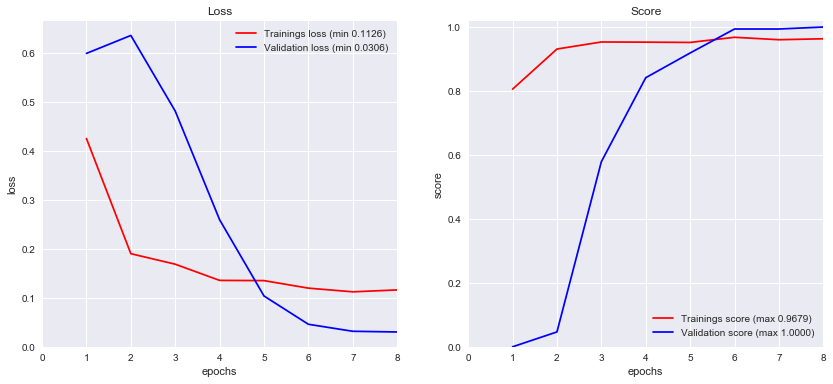

In [17]:
clf = pipeline.named_steps['classifier']
plot_loss_curve(clf.loss_train_, clf.score_train_,  clf.loss_valid_, clf.score_valid_)

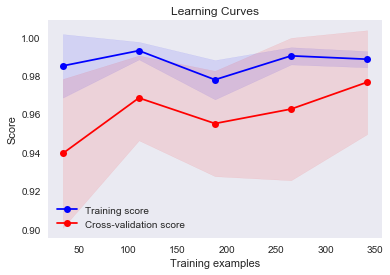

In [18]:
try:
    cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_train)
    plot_learning_curve(pipeline, 'Learning Curves', X_train, y_train, cv=cv, shuffle=True, 
                        n_jobs=4, random_state=HP.SEED)
except:
    pass